# 1. Import packages and dataset

In [1]:
# Data processing and visualization packages
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning packages
from sklearn.pipeline import Pipeline # Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder # Features engineering
from sklearn.compose import ColumnTransformer # Features engineering
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold # Dataset splitting and Cross-Validation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # Evaluation metrics

# Models
from sklearn.linear_model import LinearRegression # Linear Regression
from sklearn.ensemble import RandomForestRegressor # Random Forest
import xgboost as xgb # XGBoost
import lightgbm as lgb # LightGBM

In [2]:
# Import raw dataset
df = pd.read_csv('canada_us_electricity_trade.csv')

# Fitler only 'export' trade type
export_df = df[df['trade_type']=='export']

# Convert 'date' column to datetime data type
export_df['date'] = pd.to_datetime(export_df['date'], dayfirst=True)

export_df.head()

C:\Users\thanh\AppData\Local\Temp\ipykernel_2840\2819942437.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df['date'] = pd.to_datetime(export_df['date'], dayfirst=True)


,utc,iso,ym,date,year,month,day,annual_hour,province,iso_info,...,geo_iso_share,gas_iso_share,other_iso_share,oil_iso_share,solar_iso_share,nuclear_iso_share,hydro_iso_share,wind_iso_share,solar_radiation,wind_speed
0,2018-01-01T04:00:00Z,ISO-NE,2018-01,2018-01-01,2018,1,1,5,NB,Maine,...,0.0,0.400581,0.000979,0.056172,0.005374,0.294260,0.076436,0.040998,0.0,4.822305
2,2018-01-01T05:00:00Z,ISO-NE,2018-01,2018-01-01,2018,1,1,6,QC,HVDC,...,0.0,0.400581,0.000979,0.056172,0.005374,0.294260,0.076436,0.040998,0.0,4.956411
3,2018-01-01T05:00:00Z,ISO-NE,2018-01,2018-01-01,2018,1,1,6,QC,Highgate,...,0.0,0.400581,0.000979,0.056172,0.005374,0.294260,0.076436,0.040998,0.0,4.956411
4,2018-01-01T05:00:00Z,ISO-NE,2018-01,2018-01-01,2018,1,1,6,NB,Maine,...,0.0,0.400581,0.000979,0.056172,0.005374,0.294260,0.076436,0.040998,0.0,4.956411
6,2018-01-01T05:00:00Z,MISO,2018-01,2018-01-01,2018,1,1,6,ON,Michigan,...,0.0,0.258830,0.010321,0.000171,0.001184,0.137615,0.014324,0.088756,0.0,4.282356


In [3]:
export_df.shape

(374178, 45)

# 2. Exploratory data analysis

## 2.1. Clean missing values

In [4]:
# Check missing value
null_check = export_df.isnull().sum()
null_check[null_check > 0]

iso_price      4
iso_load       2
henry_gas    159
aeco_gas     159
dtype: int64

### 2.1.1. iso_price

In [5]:
# Check characteristics of null rows
export_df[export_df['iso_price'].isnull()][['iso_info', 'iso_regulate', 'trade_type']]

,iso_info,iso_regulate,trade_type
212479,Northwest,Partially Deregulated,export
396930,Montana,Partially Deregulated,export
396941,Montana,Partially Deregulated,export
396963,Montana,Partially Deregulated,export


iso_price mean: 62.639647454118226
iso_price median: 50.18387333


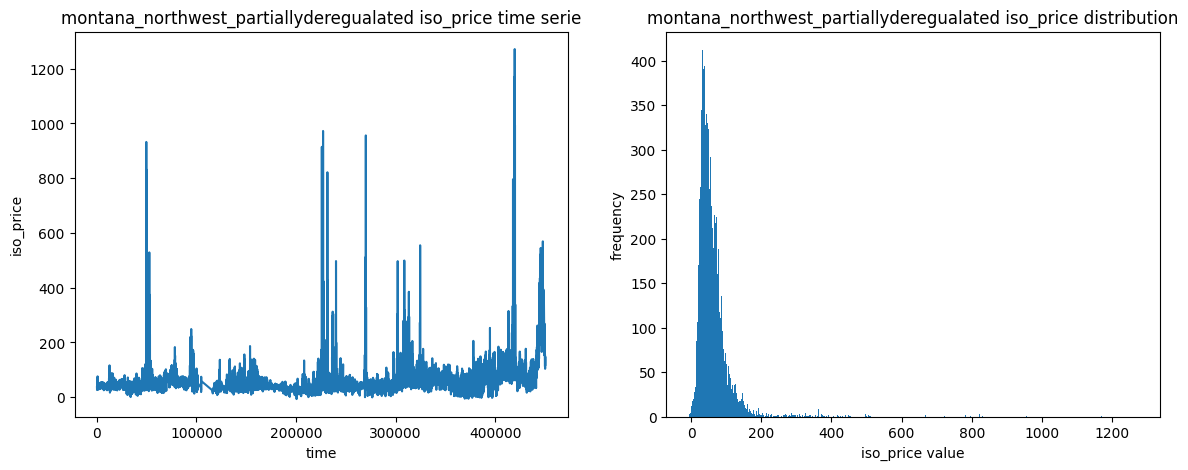

In [6]:
# Visualize to understand the non-null data pattern
iso_price_montana_northwest_partiallyderegulated_not_null = export_df[(export_df['iso_info']=='Montana') | (export_df['iso_info']=='Northwest') & export_df['iso_price'].notnull()]['iso_price']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(iso_price_montana_northwest_partiallyderegulated_not_null)
axes[0].set_title("montana_northwest_partiallyderegualated iso_price time serie")
axes[0].set_xlabel("time")
axes[0].set_ylabel("iso_price")

axes[1].hist(iso_price_montana_northwest_partiallyderegulated_not_null, bins = 2000)
axes[1].set_title("montana_northwest_partiallyderegualated iso_price distribution")
axes[1].set_xlabel("iso_price value")
axes[1].set_ylabel("frequency")

# Statistical measures
print(f'''iso_price mean: {iso_price_montana_northwest_partiallyderegulated_not_null.mean()}''')
print(f'''iso_price median: {iso_price_montana_northwest_partiallyderegulated_not_null.median()}''')

In [7]:
# Replace null values
export_df['iso_price'] = export_df['iso_price'].fillna(iso_price_montana_northwest_partiallyderegulated_not_null.median())

C:\Users\thanh\AppData\Local\Temp\ipykernel_2840\137199411.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df['iso_price'] = export_df['iso_price'].fillna(iso_price_montana_northwest_partiallyderegulated_not_null.median())


### 2.1.2. iso_load

In [8]:
# Check the characteristic of null rows
export_df[export_df['iso_load'].isnull()][['iso_info', 'iso_price', 'iso_regulate', 'trade_type']]

,iso_info,iso_price,iso_regulate,trade_type
82127,Northwest,36.802520,Partially Deregulated,export
243810,Northwest,41.250447,Partially Deregulated,export


iso_price mean: 52878.392106596715
iso_price median: 50580.0


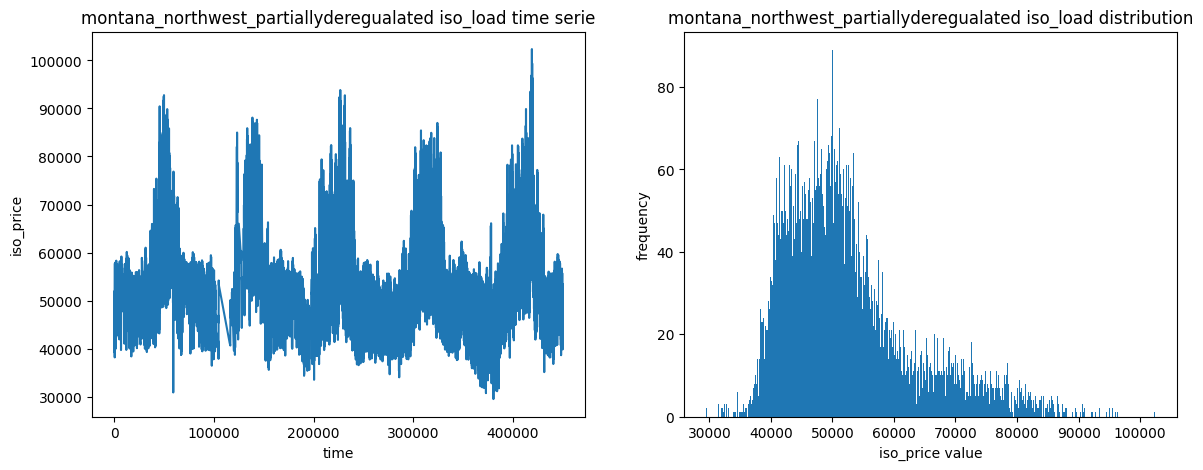

In [9]:
# Visualize to understand the non-null data pattern
iso_load_montana_northwest_partiallyderegulated_not_null = export_df[(export_df['iso_info']=='Montana') | (export_df['iso_info']=='Northwest') & export_df['iso_load'].notnull()]['iso_load']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(iso_load_montana_northwest_partiallyderegulated_not_null)
axes[0].set_title("montana_northwest_partiallyderegualated iso_load time serie")
axes[0].set_xlabel("time")
axes[0].set_ylabel("iso_price")

axes[1].hist(iso_load_montana_northwest_partiallyderegulated_not_null, bins = 2000)
axes[1].set_title("montana_northwest_partiallyderegualated iso_load distribution")
axes[1].set_xlabel("iso_price value")
axes[1].set_ylabel("frequency")

# Statistical measures
print(f'''iso_price mean: {iso_load_montana_northwest_partiallyderegulated_not_null.mean()}''')
print(f'''iso_price median: {iso_load_montana_northwest_partiallyderegulated_not_null.median()}''')

In [10]:
# Replace the null value
export_df['iso_load'] = export_df['iso_load'].fillna(iso_load_montana_northwest_partiallyderegulated_not_null.median())

C:\Users\thanh\AppData\Local\Temp\ipykernel_2840\1359225993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df['iso_load'] = export_df['iso_load'].fillna(iso_load_montana_northwest_partiallyderegulated_not_null.median())


### 2.1.3. henry_gas and aeco_gas

In [11]:
# Check the characteristic of null rows
export_df[(export_df['henry_gas'].isnull()) | (export_df['aeco_gas'].isnull())]['ym']

0      2018-01
2      2018-01
3      2018-01
4      2018-01
6      2018-01
        ...   
180    2018-01
181    2018-01
182    2018-01
183    2018-01
184    2018-01
Name: ym, Length: 159, dtype: object

Mean of henry_gas in 2018-01: 3.826751510159253
Median of henry_gas in 2018-01: 3.542
Mean of aeco_gas in 2018-01: 1.6551089239850356
Median of aeco_gas in 2018-01: 1.625180665


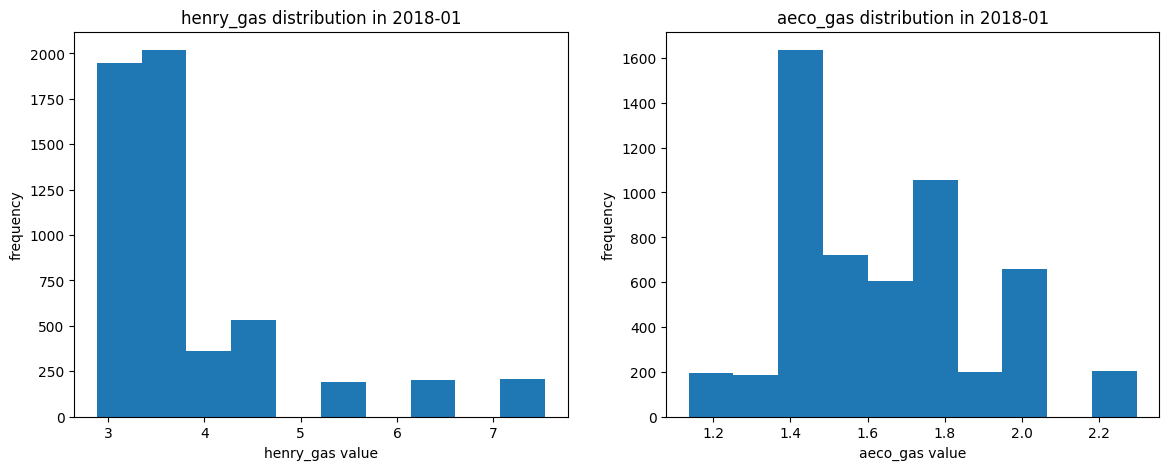

In [12]:
# Visualize to understand the non-null data pattern
henry_gas_not_null = export_df[(export_df['ym']=='2018-01') & export_df['henry_gas'].notnull()]['henry_gas']
aeco_gas_not_null = export_df[(export_df['ym']=='2018-01') & export_df['aeco_gas'].notnull()]['aeco_gas']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(henry_gas_not_null)
axes[0].set_title("henry_gas distribution in 2018-01")
axes[0].set_xlabel("henry_gas value")
axes[0].set_ylabel("frequency")

axes[1].hist(aeco_gas_not_null)
axes[1].set_title("aeco_gas distribution in 2018-01")
axes[1].set_xlabel("aeco_gas value")
axes[1].set_ylabel("frequency")

# Statistical measures
print(f'''Mean of henry_gas in 2018-01: {df[df['ym'] == '2018-01']['henry_gas'].mean()}''')
print(f'''Median of henry_gas in 2018-01: {df[df['ym'] == '2018-01']['henry_gas'].median()}''')

print(f'''Mean of aeco_gas in 2018-01: {df[df['ym'] == '2018-01']['aeco_gas'].mean()}''')
print(f'''Median of aeco_gas in 2018-01: {df[df['ym'] == '2018-01']['aeco_gas'].median()}''')

In [13]:
# Replace the null value
export_df['henry_gas'] = export_df['henry_gas'].fillna(export_df[export_df['ym'] == '2018-01']['henry_gas'].median())
export_df['aeco_gas'] = export_df['aeco_gas'].fillna(export_df[export_df['ym'] == '2018-01']['aeco_gas'].mean())

C:\Users\thanh\AppData\Local\Temp\ipykernel_2840\894271534.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df['henry_gas'] = export_df['henry_gas'].fillna(export_df[export_df['ym'] == '2018-01']['henry_gas'].median())
C:\Users\thanh\AppData\Local\Temp\ipykernel_2840\894271534.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df['aeco_gas'] = export_df['aeco_gas'].fillna(export_df[export_df['ym'] == '2018-01']['aeco_gas'].mean())


## 2.2. Create time series features

In [14]:
# Group the dataframe by 'date' and 'iso_info'
export_df_grouped = export_df.groupby(by = ['date','iso_info']).agg(mean_daily_transfers_MWh = ('transfers_MWh', 'mean')).reset_index()
export_df_grouped['date'] = pd.to_datetime(export_df_grouped['date'], dayfirst=True)
export_df_grouped = export_df_grouped.sort_values(by=['iso_info', 'date'])

# Create time series features
export_df_grouped['ma_3lag'] = export_df_grouped.groupby('iso_info')['mean_daily_transfers_MWh'].shift(1).rolling(3, min_periods=1).mean()
export_df_grouped['ma_7lag'] = export_df_grouped.groupby('iso_info')['mean_daily_transfers_MWh'].shift(1).rolling(7, min_periods=1).mean()
export_df_grouped['ma_30lag'] = export_df_grouped.groupby('iso_info')['mean_daily_transfers_MWh'].shift(1).rolling(30, min_periods=1).mean()
export_df_grouped['ma_60lag'] = export_df_grouped.groupby('iso_info')['mean_daily_transfers_MWh'].shift(1).rolling(60, min_periods=1).mean()
export_df_grouped['ma_90lag'] = export_df_grouped.groupby('iso_info')['mean_daily_transfers_MWh'].shift(1).rolling(90, min_periods=1).mean()

# Replace NaN value at the first row of time series features by the first mean_daily_transfers_MWh
export_df_grouped.reset_index()
export_df_grouped.iloc[0, 3:] = export_df_grouped.iloc[0, 2]

# Recheck the dataframe
export_df_grouped

,date,iso_info,mean_daily_transfers_MWh,ma_3lag,ma_7lag,ma_30lag,ma_60lag,ma_90lag
0,2018-01-01,Dakota,-60.000000,-60.000000,-60.000000,-60.000000,-60.000000,-60.000000
9,2018-01-02,Dakota,-47.600000,-60.000000,-60.000000,-60.000000,-60.000000,-60.000000
18,2018-01-03,Dakota,-75.000000,-53.800000,-53.800000,-53.800000,-53.800000,-53.800000
27,2018-01-04,Dakota,-48.076923,-60.866667,-60.866667,-60.866667,-60.866667,-60.866667
36,2018-01-05,Dakota,-26.666667,-56.892308,-57.669231,-57.669231,-57.669231,-57.669231
...,...,...,...,...,...,...,...,...
15623,2022-12-28,West,-1342.208333,-1148.305556,-960.928571,-793.007732,-556.147185,-578.924136
15632,2022-12-29,West,-1293.791667,-1232.472222,-1042.095238,-829.953138,-569.927740,-583.461173
15641,2022-12-30,West,-1058.875000,-1315.916667,-1136.279762,-859.917208,-582.669920,-587.481080
15649,2022-12-31,West,-650.708333,-1231.625000,-1175.755952,-878.642208,-596.559504,-589.557469


C:\Users\thanh\AppData\Local\Temp\ipykernel_2840\4134098135.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0, 0.5, 'transferred_MWh')

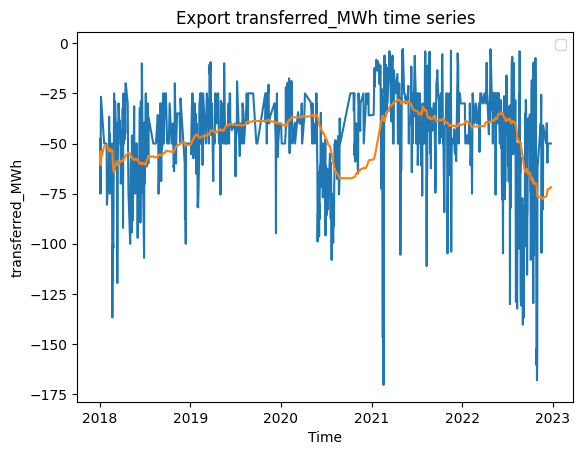

In [15]:
# Recheck the time series feature with 'Dakota' example
export_df_grouped_dakota = export_df_grouped[export_df_grouped['iso_info']=='Dakota']
plt.plot(export_df_grouped_dakota['date'], export_df_grouped_dakota['mean_daily_transfers_MWh'])
plt.plot(export_df_grouped_dakota['date'], export_df_grouped_dakota['ma_90lag'])
plt.title('Export transferred_MWh time series')
plt.legend()
plt.xlabel('Time')
plt.ylabel('transferred_MWh')

In [16]:
# Drop the 'mean_daily_transfers_MWh' column
export_df_grouped = export_df_grouped.drop(columns='mean_daily_transfers_MWh')

In [17]:
# Merge the original dataframe with new time series features
export_df_merged = pd.merge(left=export_df, right=export_df_grouped, how='inner', on=['date', 'iso_info'])

## 2.3. Distribution and correlation of numerical columns

In [18]:
# Get numerical columns
numerical_col = export_df_merged.select_dtypes(include=["int64", "float64"]).columns
numerical_col

Index(['year', 'month', 'day', 'annual_hour', 'transfers_MWh', 'price_usd',
       'price_cad', 'fx', 'iso_price', 'iso_load', 'henry_gas', 'aeco_gas',
       'bio_iso_mwh', 'coal_iso_mwh', 'storage_iso_mwh', 'geo_iso_mwh',
       'gas_iso_mwh', 'other_iso_mwh', 'oil_iso_mwh', 'solar_iso_mwh',
       'nuclear_iso_mwh', 'hydro_iso_mwh', 'wind_iso_mwh', 'total_iso_mwh',
       'bio_iso_share', 'coal_iso_share', 'storage_iso_share', 'geo_iso_share',
       'gas_iso_share', 'other_iso_share', 'oil_iso_share', 'solar_iso_share',
       'nuclear_iso_share', 'hydro_iso_share', 'wind_iso_share',
       'solar_radiation', 'wind_speed', 'ma_3lag', 'ma_7lag', 'ma_30lag',
       'ma_60lag', 'ma_90lag'],
      dtype='object')

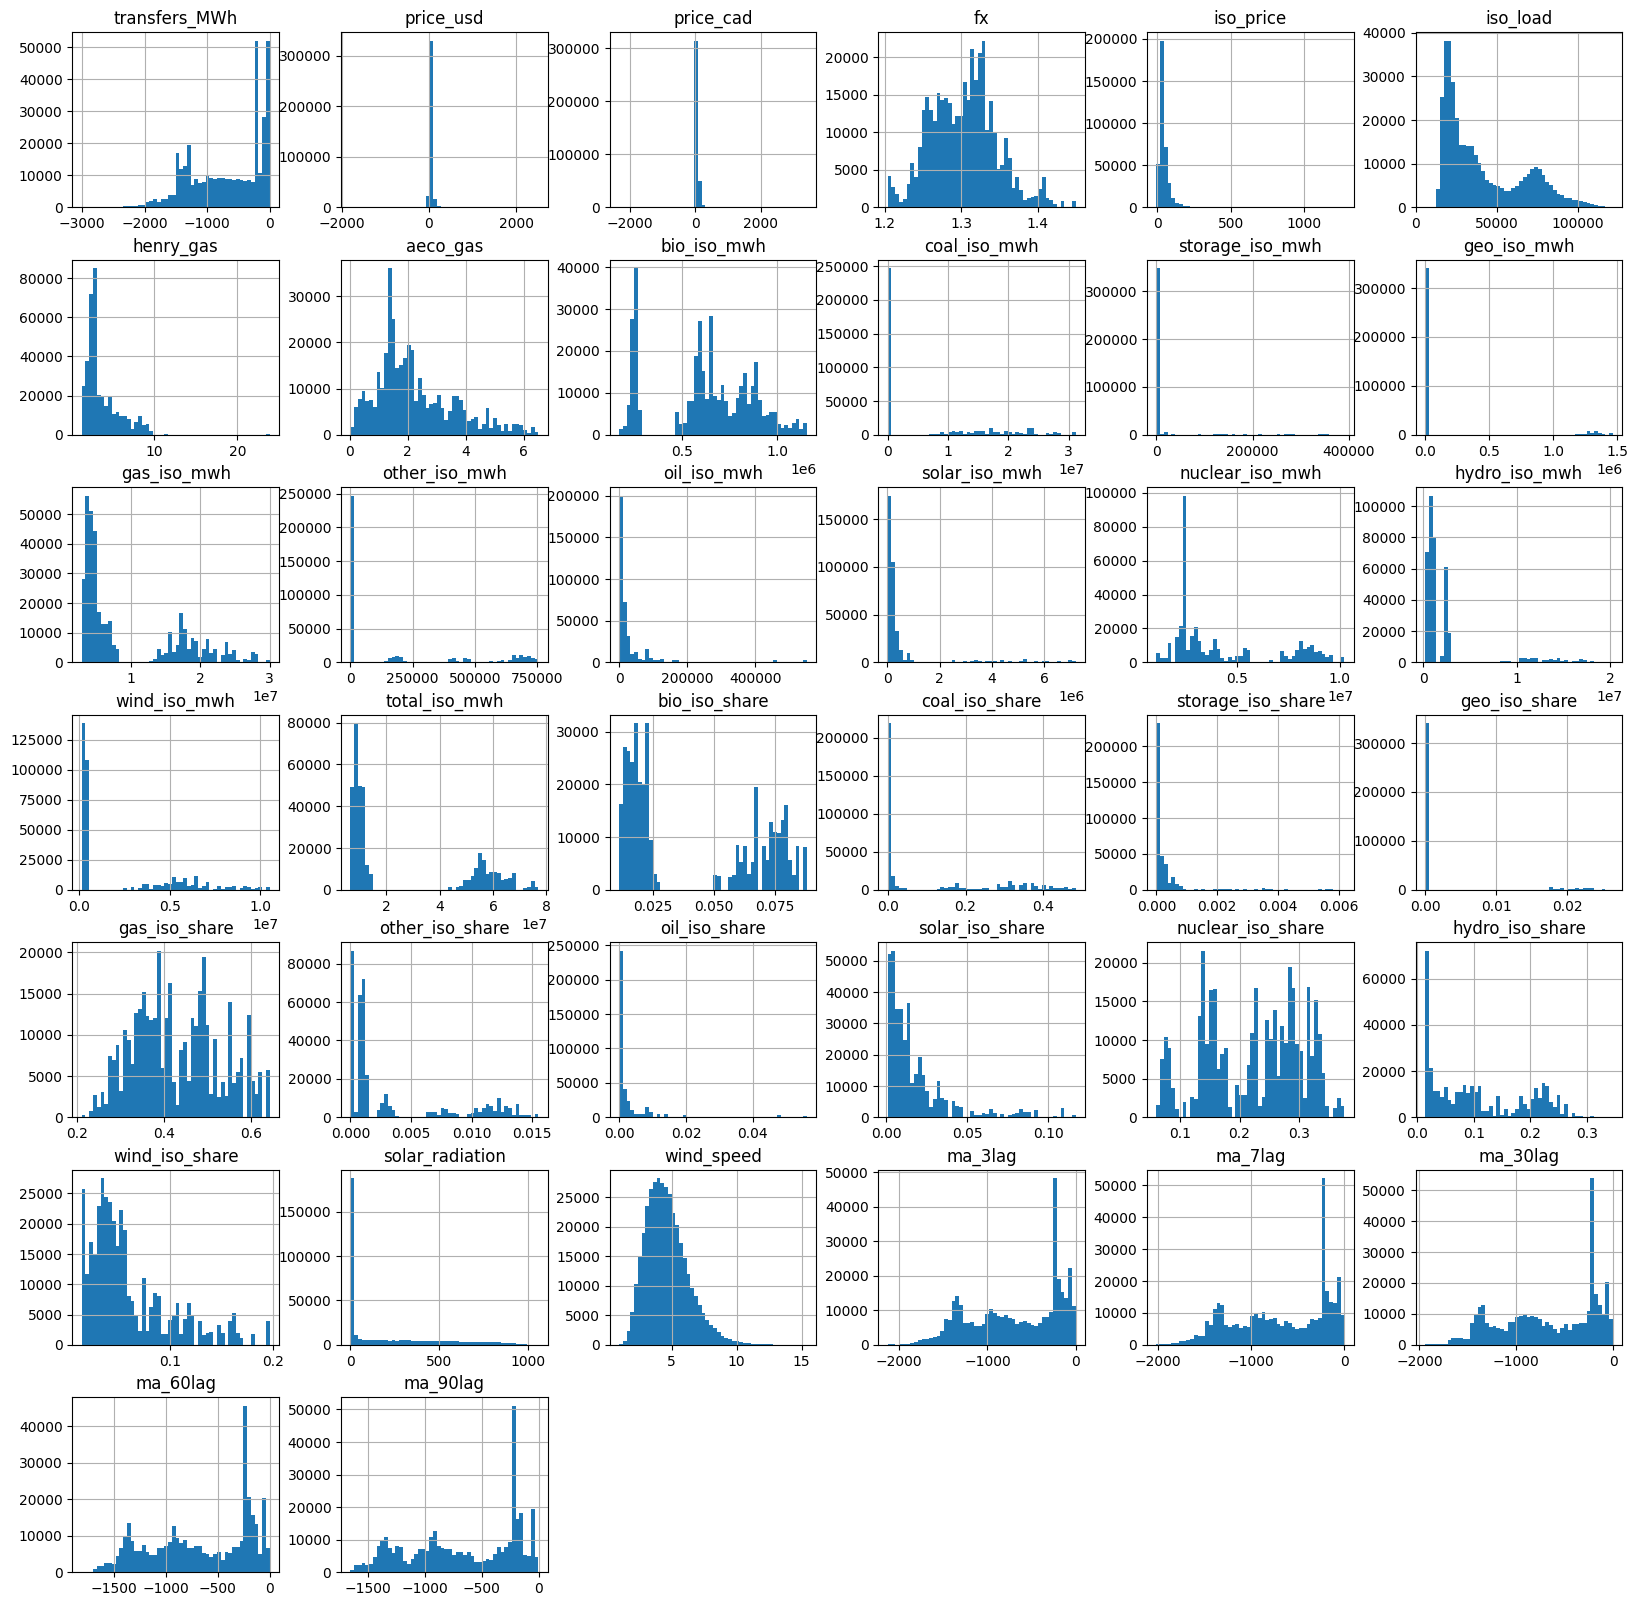

In [19]:
# Plot the distribution of numerical columns
export_df_merged[numerical_col[4:]].hist(figsize=(20, 20), bins=50)
plt.show()

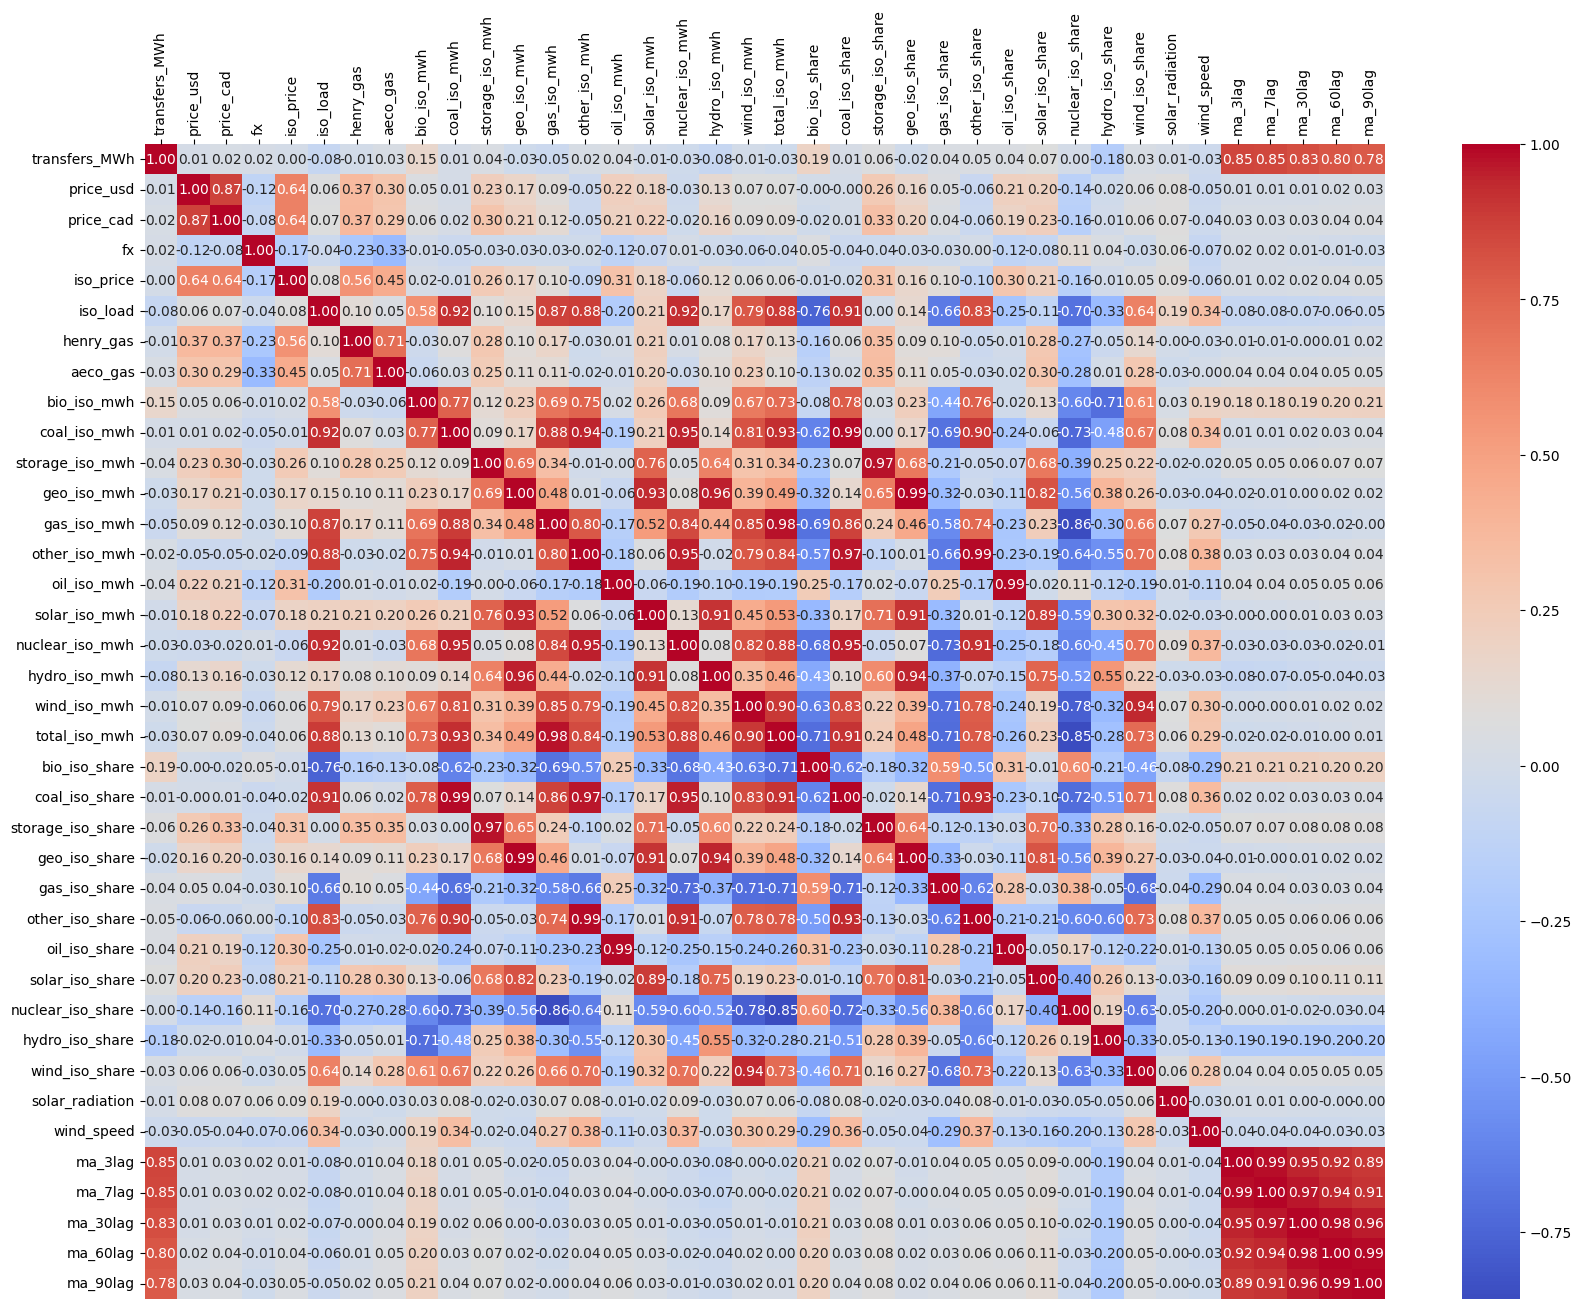

In [20]:
# Plot the correlation between variables
plt.figure(figsize=(20, 15))

ax = sns.heatmap(export_df_merged[numerical_col[4:]].corr(), annot=True, fmt=".2f", cmap="coolwarm")

ax.xaxis.set_ticks_position("top")  
ax.xaxis.set_label_position("top")  
plt.xticks(rotation=90)

plt.show()

# 3. Set up machine learning pipeline and intial models

## 3.1. Feature engineering

In [21]:
# Features
X = export_df_merged[[
    'year', 'month', 'day', 'annual_hour', # Time
    'iso', 'province', 'iso_info', # Trade Partners and location
    'trade_type', # Trade Data
    'price_usd', 'price_cad', 'fx', 'iso_price', 'iso_regulate', # Pricing information
    'iso_load', # System information
    'henry_gas', 'aeco_gas', 'solar_radiation', 'wind_speed', # Environmental factors
    'bio_iso_mwh', 'coal_iso_mwh', 'storage_iso_mwh', 'geo_iso_mwh', 'gas_iso_mwh', 'other_iso_mwh', 'oil_iso_mwh', 'solar_iso_mwh', 
    'nuclear_iso_mwh', 'hydro_iso_mwh', 'wind_iso_mwh', 'total_iso_mwh', # Generation by source in MWh
    'bio_iso_share', 'coal_iso_share', 'storage_iso_share', 'geo_iso_share', 'gas_iso_share', 'other_iso_share', 'oil_iso_share', 'solar_iso_share', 
    'nuclear_iso_share', 'hydro_iso_share', 'wind_iso_share', # Generation share by source
    'ma_3lag', 'ma_7lag', 'ma_30lag', 'ma_60lag', 'ma_90lag' # Time series features
    ]]

# Target
y = export_df_merged[['transfers_MWh']] # Electricity transferred in MWh

# Get the list of numerical and categorical features
X_num = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
X_cat = X.select_dtypes(include=["object", "category"]).columns.tolist()

# Set up transformers in a preprocessor with LogTransform, StandardScaler and OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('log', FunctionTransformer(np.log1p, validate=True), 
         ['iso_load', 'henry_gas', 'aeco_gas', 'oil_iso_mwh', 'solar_iso_mwh', 'storage_iso_share', 
          'oil_iso_share', 'solar_iso_share', 'wind_iso_share', 'solar_radiation']),
        ('num', StandardScaler(), X_num[4:]),
        ('cat', OneHotEncoder(handle_unknown='ignore'), X_cat)
    ]
)

# Split the dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## 3.2. Initial machine learning models

In [22]:
# Initial models with rule-of-thumb hyperparameters
initial_models = {
    "Linear Regression": LinearRegression(n_jobs=-1
    ),
    "Random Forest": RandomForestRegressor(
        n_estimators=100, max_depth=10, min_samples_split=5, max_features=0.8, criterion='squared_error', bootstrap=True, n_jobs=-1
    ),
    "XGBoost": xgb.XGBRegressor(
        n_estimators=100, max_depth=3, learning_rate=0.01, colsample_bytree=0.8, 
        objective="reg:squarederror", tree_method='gpu_hist', gpu_id=0, subsample=0.8 
    ),
    "LightGBM": lgb.LGBMRegressor(
        n_estimators=100, max_depth=5, learning_rate=0.01, reg_alpha=0.1, reg_lambda=0.1, 
        bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.8, 
        objective='regression', device='gpu', gpu_platform_id=0, gpu_device_id=0
    )
}

## 3.3. Train and evaluate initial models

In [23]:
# Define evaluation metrics function
def eval_kpis(y_pred, y_test):
    mae_percentage = mean_absolute_error(y_test, y_pred) / y_test.mean()
    rmse_percentage = math.sqrt(mean_squared_error(y_test, y_pred)) / y_test.mean()
    r_square = r2_score(y_test, y_pred)
    
    print(f'MAE%: {float(mae_percentage):.2f}')
    print(f'RMSE%: {float(rmse_percentage):.2f}')
    print(f'R²: {r_square:.2f}')

In [24]:
# Train and evaluate the intial models
for name, model in initial_models.items():
    print(f"Training {name}...")
    
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    print(f'{name} Performance:')
    eval_kpis(y_pred, y_test)
    print("-" * 40)

Training Linear Regression...
Linear Regression Performance:
MAE%: -0.26
RMSE%: -0.38
R²: 0.79
----------------------------------------
Training Random Forest...


C:\Users\thanh\AppData\Local\Temp\ipykernel_2840\4029147040.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f'MAE%: {float(mae_percentage):.2f}')
C:\Users\thanh\AppData\Local\Temp\ipykernel_2840\4029147040.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f'RMSE%: {float(rmse_percentage):.2f}')
C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Performance:
MAE%: -0.21
RMSE%: -0.32
R²: 0.85
----------------------------------------
Training XGBoost...


C:\Users\thanh\AppData\Local\Temp\ipykernel_2840\4029147040.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f'MAE%: {float(mae_percentage):.2f}')
C:\Users\thanh\AppData\Local\Temp\ipykernel_2840\4029147040.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f'RMSE%: {float(rmse_percentage):.2f}')
C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [21:49:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\Local

XGBoost Performance:
MAE%: -0.40
RMSE%: -0.49
R²: 0.66
----------------------------------------
Training LightGBM...


C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 10744
[LightGBM] [Info] Number of data points in the train set: 299342, number of used features: 71
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Lapto

C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\thanh\AppData\Local\Temp\ipykernel_2840\4029147040.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f'MAE%: {float(mae_percentage):.2f}')
C:\Users\thanh\AppData\Local\Temp\ipykernel_2840\4029147040.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f'RMSE%: {float(rmse_percentage):.2f}')


# 4. Tune hyperparameters and choose the best model

## 4.1. Define K-Fold Cross-Validation and hyperparameter grids for each model

In [25]:
# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True)

# Parameter grids
param_grids = {
    "Random Forest": {
        'model__n_estimators': [100, 200, 300, 400],
        'model__max_depth': [10, 20, 30, 40],
        'model__min_samples_split': [5, 10, 15, 20]
    },
    "XGBoost": {
        'model__n_estimators': [100, 200, 300, 400],
        'model__max_depth': [3, 5, 7, 9],
        'model__learning_rate': [0.01, 0.02, 0.03, 0.04]
    },
    "LightGBM": {
        'model__n_estimators': [100, 200, 300, 400],
        'model__max_depth': [5, 10, 15, 20],
        'model__learning_rate': [0.01, 0.02, 0.03, 0.04]
    }
}

## 4.2. Use Random Search for choosing the best model

In [26]:
# Models
models = {
    "Random Forest": RandomForestRegressor(
        criterion='squared_error', 
        bootstrap=True, 
        n_jobs=-1
    ),
    "XGBoost": xgb.XGBRegressor(
        objective="reg:squarederror", 
        subsample=0.8, 
        tree_method='gpu_hist', gpu_id=0
    ),
    "LightGBM": lgb.LGBMRegressor(objective='regression', reg_alpha=0.1, reg_lambda=0.1, 
                                  bagging_fraction=0.8, bagging_freq=5, 
                                  device='gpu', gpu_platform_id=0, gpu_device_id=0
    )
}

# Dictionary to store best model and score
best_models = {}
best_scores = {}

for name, model in models.items():
    print(f"Tuning {name} with RandomizedSearchCV and {kf.get_n_splits()}-Fold CV...")
    
    # Pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Random Search with K-Fold Cross-Validation
    random_search  = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grids[name], cv=kf, n_iter=10, 
                                        scoring="neg_mean_squared_error", n_jobs=-1, verbose=1)
    random_search.fit(X_train, y_train)
    
    # Store best model and score
    best_models[name] = random_search.best_estimator_
    best_scores[name] = -random_search.best_score_
    
    print(f"Best parameters for {name}: {random_search.best_params_}")
    print(f"Best MSE: {-random_search.best_score_:.4f}")
    print("-" * 50)

# Select the best model based on MSE
best_model_name = min(best_scores, key=best_scores.get)
best_model = best_models[best_model_name]

print(f"Best overall model: {best_model_name}")

Tuning Random Forest with RandomizedSearchCV and 5-Fold CV...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best parameters for Random Forest: {'model__n_estimators': 300, 'model__min_samples_split': 5, 'model__max_depth': 40}
Best MSE: 27339.4645
--------------------------------------------------
Tuning XGBoost with RandomizedSearchCV and 5-Fold CV...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [15:10:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters for XGBoost: {'model__n_estimators': 300, 'model__max_depth': 7, 'model__learning_rate': 0.04}
Best MSE: 40471.8898
--------------------------------------------------
Tuning LightGBM with RandomizedSearchCV and 5-Fold CV...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 10728
[LightGBM] [Info] Number of data points in the train set: 299342, number of used features: 71
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 49 dense feature groups (14.84 MB) transf

# 5. Evaluate the best model with evaluation set

In [27]:
# The best model pipeline
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True),
                                                  ['iso_load', 'henry_gas',
                                                   'aeco_gas', 'oil_iso_mwh',
                                                   'solar_iso_mwh',
                                                   'storage_iso_share',
                                                   'oil_iso_share',
                                                   'solar_iso_share',
                                                   'wind_iso_share',
                                                   'solar_radiation']),
                                                 ('num', StandardScaler(),
                                                  ['price_usd', 'price_cad',
                                                   'fx', 'iso_price',
                                                   'i...
                                                   'bio_iso_share',
                                                   'coal_iso_share',
                                                   'storage_iso_share',
                                                   'geo_iso_share',
                                                   'gas_iso_share',
                                                   'other_iso_share',
                                                   'oil_iso_share',
                                                   'solar_iso_share',
                                                   'nuclear_iso_share', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['iso', 'province',
                                                   'iso_info', 'trade_type',
                                                   'iso_regulate'])])),
                ('model',
                 RandomForestRegressor(max_depth=40, min_samples_split=5,
                                       n_estimators=300, n_jobs=-1))])

In [28]:
# Evaluate the best model with evaluation set
y_best_pred = best_model.predict(X_test)
eval_kpis(y_best_pred, y_test)

MAE%: -0.14
RMSE%: -0.24
R²: 0.92


C:\Users\thanh\AppData\Local\Temp\ipykernel_2032\2542042209.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f'MAE%: {float(mae_percentage):.2f}')
C:\Users\thanh\AppData\Local\Temp\ipykernel_2032\2542042209.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f'RMSE%: {float(rmse_percentage):.2f}')


# 6. Analyse feature importance

In [29]:
# The best model
best_rf_model = best_models["Random Forest"].named_steps['model']
best_rf_model

RandomForestRegressor(max_depth=40, min_samples_split=5, n_estimators=300,
                      n_jobs=-1)

In [30]:
# Get the feature names
preprocessor = best_models["Random Forest"].named_steps['preprocessor']

feature_names = []
for name, transformer, cols in preprocessor.transformers_:
    if hasattr(transformer, "get_feature_names_out"):
        feature_names.extend(transformer.get_feature_names_out())
    else:
        # Use original column names if `get_feature_names_out()` is not available
        feature_names.extend(cols if isinstance(cols, list) else [cols])
feature_names = feature_names[:-1]
print(feature_names)

['iso_load', 'henry_gas', 'aeco_gas', 'oil_iso_mwh', 'solar_iso_mwh', 'storage_iso_share', 'oil_iso_share', 'solar_iso_share', 'wind_iso_share', 'solar_radiation', 'price_usd', 'price_cad', 'fx', 'iso_price', 'iso_load', 'henry_gas', 'aeco_gas', 'solar_radiation', 'wind_speed', 'bio_iso_mwh', 'coal_iso_mwh', 'storage_iso_mwh', 'geo_iso_mwh', 'gas_iso_mwh', 'other_iso_mwh', 'oil_iso_mwh', 'solar_iso_mwh', 'nuclear_iso_mwh', 'hydro_iso_mwh', 'wind_iso_mwh', 'total_iso_mwh', 'bio_iso_share', 'coal_iso_share', 'storage_iso_share', 'geo_iso_share', 'gas_iso_share', 'other_iso_share', 'oil_iso_share', 'solar_iso_share', 'nuclear_iso_share', 'hydro_iso_share', 'wind_iso_share', 'ma_3lag', 'ma_7lag', 'ma_30lag', 'ma_60lag', 'ma_90lag', 'iso_ISO-NE', 'iso_MISO', 'iso_NYISO', 'iso_WECC', 'province_AB', 'province_BC', 'province_MB', 'province_NB', 'province_ON', 'province_QC', 'province_SK', 'iso_info_Dakota', 'iso_info_HQ', 'iso_info_HVDC', 'iso_info_Highgate', 'iso_info_Maine', 'iso_info_Michig

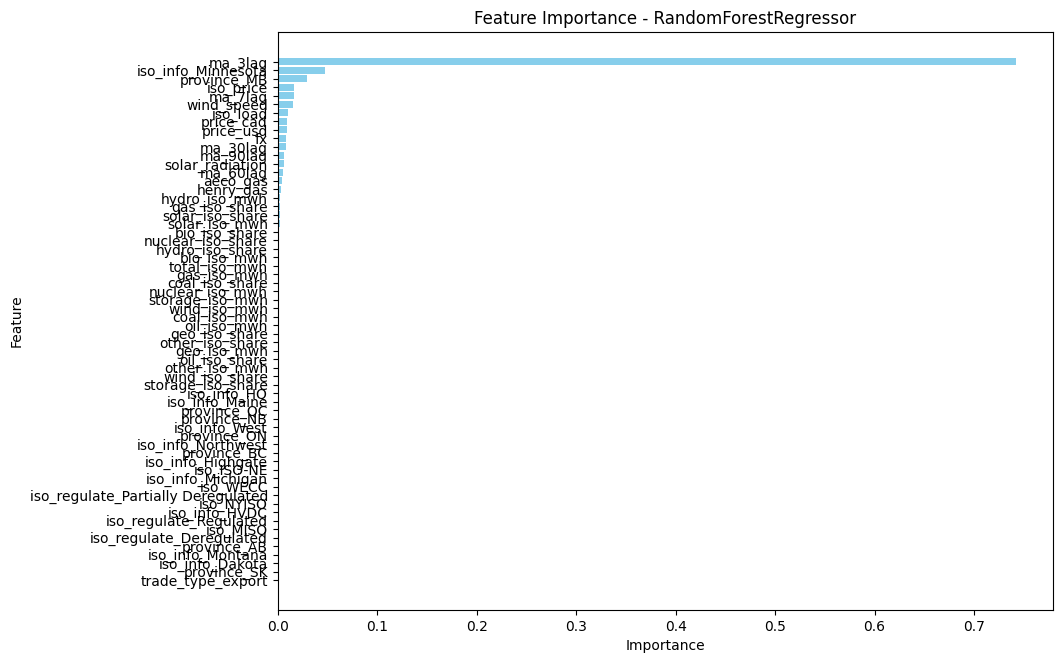

In [62]:
# Get feature importance values
feature_importance = best_rf_model.feature_importances_

# Create a DataFrame
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 7.5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - RandomForestRegressor')
plt.gca().invert_yaxis()
plt.show()

In [52]:
# Define a threshold of 95% feature importance
importance_df['Cumulative Importance'] = importance_df['Importance'].cumsum()
threshold = 0.95
selected_features = importance_df[importance_df['Cumulative Importance'] <= threshold]
print(selected_features)

               Feature  Importance  Cumulative Importance
42             ma_3lag    0.741924               0.741924
64  iso_info_Minnesota    0.047779               0.789703
53         province_MB    0.029269               0.818972
13           iso_price    0.016900               0.835872
43             ma_7lag    0.016242               0.852114
18          wind_speed    0.015333               0.867447
14            iso_load    0.010220               0.877667
0             iso_load    0.010185               0.887852
11           price_cad    0.009605               0.897457
10           price_usd    0.009187               0.906644
12                  fx    0.008344               0.914988
44            ma_30lag    0.007894               0.922882
46            ma_90lag    0.006511               0.929393
9      solar_radiation    0.006112               0.935505
17     solar_radiation    0.005820               0.941325
45            ma_60lag    0.005629               0.946954


# 7. Evaluate the best model with key features

In [56]:
# Key feature
X_key = pd.get_dummies(X)[['ma_3lag', 'iso_info_Minnesota', 'province_MB', 
                           'iso_price', 'ma_7lag', 'wind_speed', 'iso_load', 'price_cad',
                           'price_usd', 'fx', 'ma_30lag', 'ma_90lag', 'solar_radiation', 'ma_60lag']]

# Split training and evaluation set
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_key, y, test_size=0.2, random_state=None)

In [57]:
# Fit the best model with key features
best_model_with_key_features = RandomForestRegressor(max_depth=40, min_samples_split=5, n_estimators=300, n_jobs=-1)
best_model_with_key_features.fit(X_train_final, y_train_final)

C:\Users\thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=40, min_samples_split=5, n_estimators=300,
                      n_jobs=-1)

In [58]:
# Evaluate the best model with key features
y_pred_final = best_model_with_key_features.predict(X_test_final)
eval_kpis(y_pred=y_pred_final, y_test=y_test_final)

MAE%: -0.15
RMSE%: -0.24
R²: 0.91


C:\Users\thanh\AppData\Local\Temp\ipykernel_2032\2542042209.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f'MAE%: {float(mae_percentage):.2f}')
C:\Users\thanh\AppData\Local\Temp\ipykernel_2032\2542042209.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f'RMSE%: {float(rmse_percentage):.2f}')
